In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [15,8]


In [81]:
class CLA:
    
    def __init__(self,mean,covar,lB,uB):
        # Initialize the class
        self.mean=mean
        self.covar=covar
        self.lB=lB
        self.uB=uB
        self.w=[] # solution
        self.l=[] # lambdas
        self.g=[] # gammas
        self.f=[] # free weights
#---------------------------------------------------------------
    def solve(self):
        # Compute the turning points,free sets and weights
        f,w=self.initAlgo()
        self.w.append(np.copy(w)) # store solution
        self.l.append(-np.inf)
        self.g.append(-np.inf)
        self.f.append(f[:])
        while True:
            #1) case a): Bound one free weight
            l_in= -np.inf
            if len(f)>1:
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
                j=0
                for i in f:
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,j,[self.lB[i],self.uB[i]])
                    if l>l_in:l_in,i_in,bi_in=l,i,bi
                    j+=1
            #2) case b): Free one bounded weight
            l_out=-np.inf
            if len(f)<self.mean.shape[0]:
                b=self.getB(f)
                for i in b:
                    covarF,covarFB,meanF,wB=self.getMatrices(f+[i])
                    covarF_inv=np.linalg.inv(covarF)
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,meanF.shape[0]-1, \
                        self.w[-1][i])
                    if (self.l[-1]==-np.inf or l<self.l[-1]) and l>l_out:l_out,i_out=l,i                
            if (l_in==-np.inf or l_in<0) and (l_out==-np.inf or l_out<0):
                #3) compute minimum variance solution
                self.l.append(0)
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
                meanF=np.zeros(meanF.shape)
            else:
                #4) decide lambda
                if l_in>l_out:
                    self.l.append(l_in)
                    f.remove(i_in)
                    w[i_in]=bi_in # set value at the correct boundary
                else:
                    self.l.append(l_out)
                    f.append(i_out)
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
            #5) compute solution vector
            wF,g=self.computeW(covarF_inv,covarFB,meanF,wB)
            for i in range(len(f)):w[f[i]]=wF[i]
            self.w.append(np.copy(w)) # store solution
            self.g.append(g)
            self.f.append(f[:])
            if self.l[-1]==0:break
        #6) Purge turning points
        self.purgeNumErr(10e-10)
        self.purgeExcess()
#---------------------------------------------------------------    
    def initAlgo(self):
        # Initialize the algo
        #1) Form structured array
        a=np.zeros((self.mean.shape[0]),dtype=[('id',int),('mu',float)])
        b=[self.mean[i][0] for i in range(self.mean.shape[0])] # dump array into list
        a[:]=list(zip(range(self.mean.shape[0]),b)) # fill structured array
        #2) Sort structured array
        b=np.sort(a,order='mu')
        #3) First free weight
        i,w=b.shape[0],np.copy(self.lB)
        while sum(w)<1:
            i-=1
            w[b[i][0]]=self.uB[b[i][0]]
        w[b[i][0]]+=1-sum(w)
        return [b[i][0]],w
#---------------------------------------------------------------    
    def computeBi(self,c,bi):
        if c>0:
            bi=bi[1][0]
        if c<0:
            bi=bi[0][0]
        return bi
#---------------------------------------------------------------
    def computeW(self,covarF_inv,covarFB,meanF,wB):
        #1) compute gamma
        onesF=np.ones(meanF.shape)
        g1=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        g2=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        if (wB is None) or (wB.sum() == 0):
            g,w1=float(-self.l[-1]*g1/g2+1/g2),0
        else:
            onesB=np.ones(wB.shape)
            g3=np.dot(onesB.T,wB)
            g4=np.dot(covarF_inv,covarFB)
            w1=np.dot(g4,wB)
            g4=np.dot(onesF.T,w1)
            g=float(-self.l[-1]*g1/g2+(1-g3+g4)/g2)
        #2) compute weights
        w2=np.dot(covarF_inv,onesF)
        w3=np.dot(covarF_inv,meanF)
        return -w1+g*w2+self.l[-1]*w3,g
#---------------------------------------------------------------
    def computeLambda(self,covarF_inv,covarFB,meanF,wB,i,bi):
        #1) C
        onesF=np.ones(meanF.shape)
        c1=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        c2=np.dot(covarF_inv,meanF)
        c3=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        c4=np.dot(covarF_inv,onesF)
        c=-c1*c2[i]+c3*c4[i]
        if c==0:return -np.inf,-np.inf
        #2) bi
        if type(bi)==list:bi=self.computeBi(c,bi)
        #3) Lambda
        if (wB is None) or (wB.sum() == 0):
            # All free assets
            return float((c4[i]-c1*bi)/c),bi
        
        else:
            onesB=np.ones(wB.shape)
            l1=np.dot(onesB.T,wB)
            l2=np.dot(covarF_inv,covarFB)
            l3=np.dot(l2,wB)
            l2=np.dot(onesF.T,l3)
            return float(((1-l1+l2)*c4[i]-c1*(bi+l3[i]))/c),bi
#---------------------------------------------------------------
    def getMatrices(self,f):
        # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
        covarF=self.reduceMatrix(self.covar,f,f)
        meanF=self.reduceMatrix(self.mean,f,[0])
        b=self.getB(f)
        covarFB=self.reduceMatrix(self.covar,f,b)
        wB=self.reduceMatrix(self.w[-1],b,[0])
        return covarF,covarFB,meanF,wB
#---------------------------------------------------------------
    def getB(self,f):
        return self.diffLists(range(self.mean.shape[0]),f)
#---------------------------------------------------------------
    def diffLists(self,list1,list2):
        return list(set(list1)-set(list2))
#---------------------------------------------------------------
    def reduceMatrix(self,matrix,listX,listY):
        # Reduce a matrix to the provided list of rows and columns
        if len(listX)==0 or len(listY)==0:return
        matrix_=matrix[:,listY[0]:listY[0]+1]
        for i in listY[1:]:
            a=matrix[:,i:i+1]
            matrix_=np.append(matrix_,a,1)
        matrix__=matrix_[listX[0]:listX[0]+1,:]
        for i in listX[1:]:
            a=matrix_[i:i+1,:]
            matrix__=np.append(matrix__,a,0)
        return matrix__
#---------------------------------------------------------------    
    def purgeNumErr(self,tol):
        # Purge violations of inequality constraints (associated with ill-conditioned covar matrix)
        i=0
        while True:
            flag=False
            if i==len(self.w):break
            if abs(sum(self.w[i])-1)>tol:
                flag=True
            else:
                for j in range(self.w[i].shape[0]):
                    if self.w[i][j]-self.lB[j]<-tol or self.w[i][j]-self.uB[j]>tol:
                        flag=True;break
            if flag==True:
                del self.w[i]
                del self.l[i]
                del self.g[i]
                del self.f[i]
            else:
                i+=1
        return
#---------------------------------------------------------------    
    def purgeExcess(self):
        # Remove violations of the convex hull
        i,repeat=0,False
        while True:
            if repeat==False:i+=1
            if i==len(self.w)-1:break
            w=self.w[i]
            mu=np.dot(w.T,self.mean)[0,0]
            j,repeat=i+1,False
            while True:
                if j==len(self.w):break
                w=self.w[j]
                mu_=np.dot(w.T,self.mean)[0,0]
                if mu<mu_:
                    del self.w[i]
                    del self.l[i]
                    del self.g[i]
                    del self.f[i]
                    repeat=True
                    break
                else:
                    j+=1
        return
#---------------------------------------------------------------
    def getMinVar(self):
        # Get the minimum variance solution
        var=[]
        for w in self.w:
            a=np.dot(np.dot(w.T,self.covar),w)
            var.append(a)
        return min(var)**.5,self.w[var.index(min(var))]
#---------------------------------------------------------------
    def getMaxSR(self):
        # Get the max Sharpe ratio portfolio
        #1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr,sr=[],[]
        for i in range(len(self.w)-1):
            w0=np.copy(self.w[i])
            w1=np.copy(self.w[i+1])
            kargs={'minimum':False,'args':(w0,w1)}
            a,b=self.goldenSection(self.evalSR,0,1,**kargs)
            w_sr.append(a*w0+(1-a)*w1)
            sr.append(b)
        return max(sr),w_sr[sr.index(max(sr))]
#---------------------------------------------------------------
    def evalSR(self,a,w0,w1):
        # Evaluate SR of the portfolio within the convex combination
        w=a*w0+(1-a)*w1
        b=np.dot(w.T,self.mean)[0,0]
        c=np.dot(np.dot(w.T,self.covar),w)[0,0]**.5
        return b/c
#---------------------------------------------------------------
    def goldenSection(self,obj,a,b,**kargs):
        # Golden section method. Maximum if kargs['minimum']==False is passed 
        from math import log,ceil
        tol,sign,args=1.0e-9,1,None
        if 'minimum' in kargs and kargs['minimum']==False:sign=-1
        if 'args' in kargs:args=kargs['args']
        numIter=int(ceil(-2.078087*log(tol/abs(b-a))))
        r=0.618033989
        c=1.0-r
        # Initialize
        x1=r*a+c*b;x2=c*a+r*b
        f1=sign*obj(x1,*args);f2=sign*obj(x2,*args)
        # Loop
        for i in range(numIter):
            if f1>f2:
                a=x1
                x1=x2;f1=f2
                x2=c*a+r*b;f2=sign*obj(x2,*args)
            else:
                b=x2
                x2=x1;f2=f1
                x1=r*a+c*b;f1=sign*obj(x1,*args)
        if f1<f2:return x1,sign*f1
        else:return x2,sign*f2
#---------------------------------------------------------------
    def efFrontier(self,points):
        # Get the efficient frontier
        mu,sigma,weights=[],[],[]
        a=np.linspace(0,1,points/len(self.w))[:-1] # remove the 1, to avoid duplications
        b=range(len(self.w)-1)
        for i in b:
            w0,w1=self.w[i],self.w[i+1]
            if i==b[-1]:a=np.linspace(0,1,points/len(self.w)) # include the 1 in the last iteration
            for j in a:
                w=w1*j+(1-j)*w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T,self.mean)[0,0])
                sigma.append(np.dot(np.dot(w.T,self.covar),w)[0,0]**.5)
        return mu,sigma,weights

def plot2D(x,y,xLabel='',yLabel='',title='',pathChart=None, extra_point = None):
    import matplotlib.pyplot as mpl
    fig=mpl.figure()
    ax=fig.add_subplot(1,1,1) #one row, one column, first plot
    ax.plot(x,y,color='blue')
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel,rotation=90)
    mpl.xticks(rotation='vertical')
    mpl.title(title)
    
    if extra_point != None:
        plt.plot(extra_point[0],extra_point[1],
                 'ro',label='r = {}, stdev = {}'.format(extra_point[1],extra_point[0]))
        ax.legend(loc='best')
    if pathChart==None:
        mpl.show()
    else:
        mpl.savefig(pathChart)
    mpl.clf() # reset pylab
    
    return

In [86]:
#1) Path
path='CLA_Data.csv'
#2) Load data, set seed
headers=open(path,'r').readline()[:-1].split(',')
data=np.genfromtxt(path,delimiter=',',skip_header=1) # load as numpy array
mean=np.array(data[:1]).T
initial_w=np.array(data[1:2]).T
lB=np.array(data[2:3]).T
uB=np.array(data[3:4]).T
covar=np.array(data[4:])
#3) Invoke object
cla=CLA(mean,covar,lB,uB)
cla.solve()
# print (cla.w)# print all turning points

In [79]:
initial_port_stdev

0.0082

In [98]:
cla.w

[array([[0.52875],
        [0.08925],
        [0.     ],
        [0.01905],
        [0.0114 ],
        [0.11955],
        [0.02185],
        [0.02385],
        [0.0637 ],
        [0.     ],
        [0.1226 ]]), array([[0.52875],
        [0.08925],
        [0.     ],
        [0.01905],
        [0.0114 ],
        [0.11955],
        [0.02185],
        [0.02385],
        [0.0637 ],
        [0.     ],
        [0.1226 ]]), array([[0.52875],
        [0.08925],
        [0.     ],
        [0.01075],
        [0.0114 ],
        [0.11955],
        [0.02185],
        [0.02385],
        [0.072  ],
        [0.     ],
        [0.1226 ]]), array([[0.52875],
        [0.08925],
        [0.     ],
        [0.01075],
        [0.0114 ],
        [0.11955],
        [0.02185],
        [0.02385],
        [0.072  ],
        [0.     ],
        [0.1226 ]]), array([[0.52875],
        [0.08925],
        [0.     ],
        [0.01075],
        [0.0114 ],
        [0.11955],
        [0.02185],
        [0.02385],
        

In [106]:
df_efficient_ports = pd.DataFrame()

for i in range(len(cla.w)):
    
    df_temp = pd.DataFrame(index = [i], data = cla.w[i].T)
    ret_temp = cla.w[i].T.dot(mean)[0][0]
    stdev_temp = cla.w[i].T.dot(mean).dot(cla.w[i])
    
    df_efficient_ports = df_efficient_ports.append(df_temp)

In [119]:
df_port_returns = df_efficient_ports.values.dot(mean)
df_port_stdev = df_efficient_ports.values.dot(covar).dot(df_efficient_ports.values.T)

ValueError: shapes (12,11) and (12,11) not aligned: 11 (dim 1) != 12 (dim 0)

In [126]:
i = 1
cla.w[i].T.dot(mean).dot(cla.w[i])

ValueError: shapes (1,1) and (11,1) not aligned: 1 (dim 1) != 11 (dim 0)

In [115]:
initial_port_return = round((initial_w.T.dot(mean))[0][0],4)
initial_port_stdev = round((initial_w.T.dot(covar).dot(initial_w))[0][0]**0.5, 4)

In [113]:
df_port_return = df_efficient_ports.values.dot(mean)
df_port_return = df_efficient_ports.values.dot(mean)

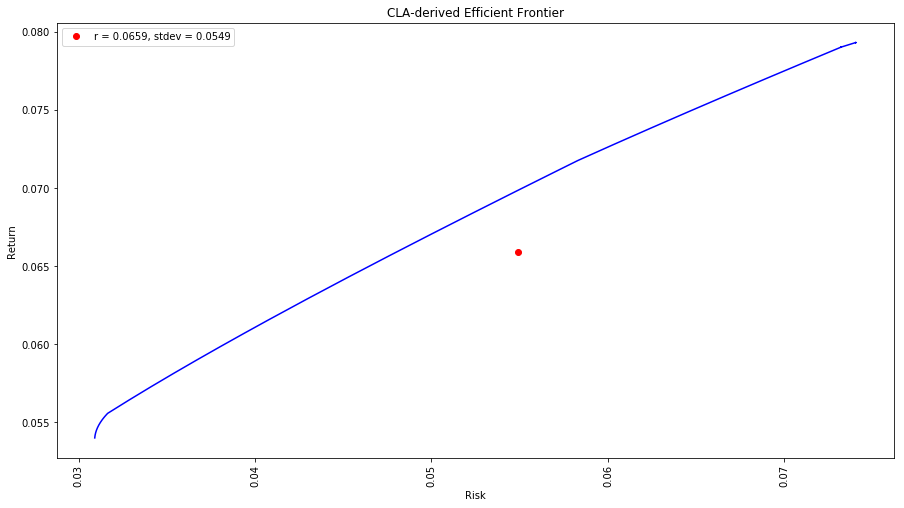

<Figure size 1080x576 with 0 Axes>

In [116]:
#4) Plot frontier
mu,sigma,weights=cla.efFrontier(100)
plot2D(sigma,mu,'Risk','Return','CLA-derived Efficient Frontier',None,[initial_port_stdev,initial_port_return])

In [89]:
#5) Get Maximum Sharpe ratio portfolio
sr,w_sr=cla.getMaxSR()
print ('\nMaximum Sharpe ratio portfolio')
print (w_sr.T.dot(mean)[0][0], np.dot(np.dot(w_sr.T,cla.covar),w_sr)[0,0]**.5, sr)
print (w_sr.T.round(4))


Maximum Sharpe ratio portfolio
0.05498340913848971 0.031233495282645858 1.7603988487654125
[[0.1762 0.0598 0.     0.0107 0.0114 0.1196 0.0218 0.0415 0.1911 0.
  0.3678]]


In [90]:
#6) Get Minimum Variance portfolio
mv,w_mv=cla.getMinVar()
print ('\nMinimum Variance portfolio')
print (w_mv.T.dot(mean)[0][0], np.dot(np.dot(w_mv.T,cla.covar),w_mv)[0,0]**.5, mv[0][0])
print (w_mv.T.round(4))


Minimum Variance portfolio
0.053992225000000005 0.03091499160399368 0.03091499160399368
[[0.1762 0.0298 0.     0.0107 0.0114 0.1196 0.0218 0.0716 0.1911 0.
  0.3678]]
